In [1]:
# Installation silencieuse et optimisée des bibliothèques
!pip install --prefer-binary -r requirements.txt

In [2]:
# --- 1. IMPORTATION OUTILS  ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from io import BytesIO
from dotenv import load_dotenv
import boto3

# --- 2. OUTILS MACHINE LEARNING (Scikit-Learn) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# --- 3. CHARGEMENT DES ACCÈS ---
load_dotenv()

# --- 4. RÉCUPÉRATION DES DONNÉES DEPUIS LE DATA LAKE ---
def load_from_s3(file_name):
    # Connexion avec les id
    s3 = boto3.client(
        's3',
        aws_access_key_id=os.getenv('ACCESS_KEY'),
        aws_secret_access_key=os.getenv('SECRET_KEY'),
        region_name="eu-west-3"
    )
    
    # Lecture du flux de données
    bucket_name = os.getenv('BUCKET_NAME')
    obj = s3.get_object(Bucket=bucket_name, Key=file_name)
    
    # On ramène le fichier nettoyé dans un DataFrame
    data = pd.read_csv(BytesIO(obj['Body'].read()), sep=';')
    return data

# --- 5. INITIALISATION ---
df = load_from_s3("bank_marketing_cleaned_v1.csv")

print(f"✅ Données chargées avec succès depuis S3.")
print(f"📊 Dimensions du dataset : {df.shape}")
df.head()

✅ Données chargées avec succès depuis S3.
📊 Dimensions du dataset : (45211, 18)


,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,solde_bancaire,pret_immo,pret_conso,day,mois,duration,campaign,pdays,previous,resultat_precedent,souscription,segment_contact,age_group
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,no existant,no,Jamais contacte,Matures(46-63)
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,no existant,no,Jamais contacte,Adultes(31-45)
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,no existant,no,Jamais contacte,Adultes(31-45)
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,-1,0,no existant,no,Jamais contacte,Matures(46-63)
4,33,unknown,single,unknown,no,1,no,no,5,may,198,1,-1,0,no existant,no,Jamais contacte,Adultes(31-45)


## Preprocessing 

## I - Lancement d'un plan Machine Learning avec la variable 'duration' 

In [3]:
#1)  Supprimer les colonnes inutiles :

colonnes_inutiles = ['pdays','age_group']
df_clean = df.drop(columns =colonnes_inutiles)
df_clean.head()


,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,solde_bancaire,pret_immo,pret_conso,day,mois,duration,campaign,previous,resultat_precedent,souscription,segment_contact
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,0,no existant,no,Jamais contacte
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,0,no existant,no,Jamais contacte
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,0,no existant,no,Jamais contacte
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,0,no existant,no,Jamais contacte
4,33,unknown,single,unknown,no,1,no,no,5,may,198,1,0,no existant,no,Jamais contacte


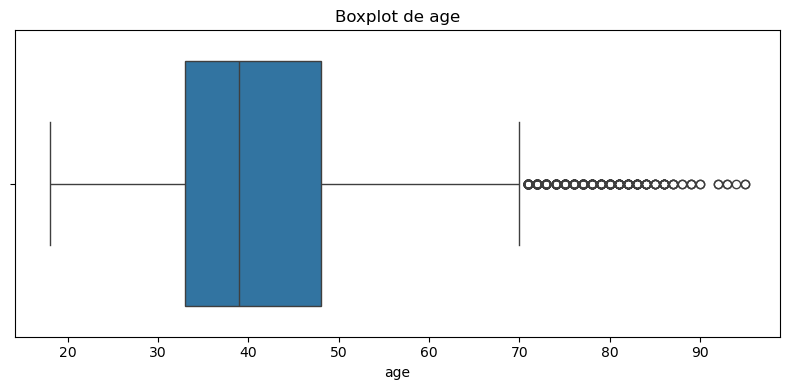

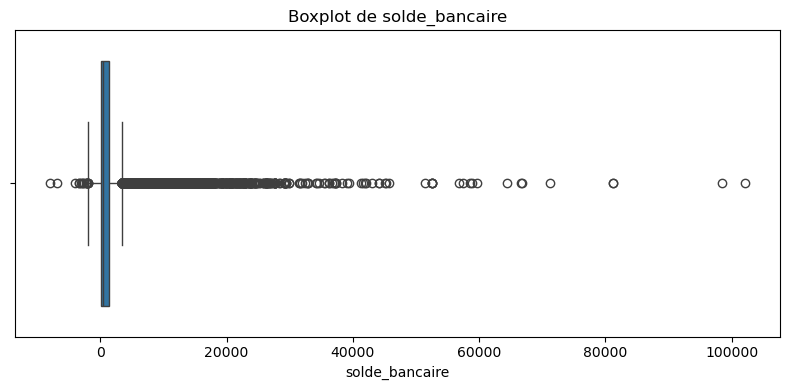

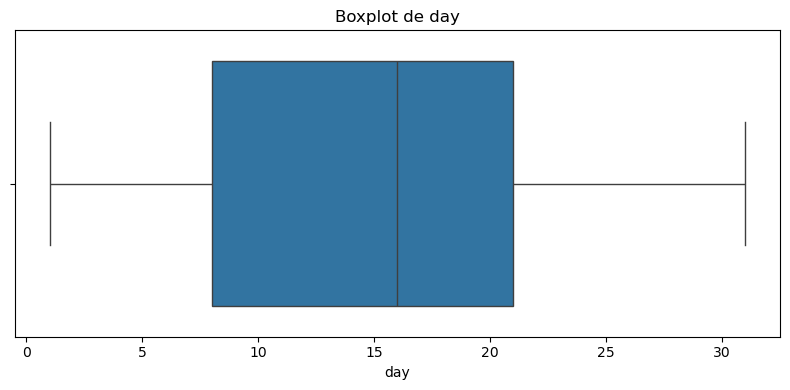

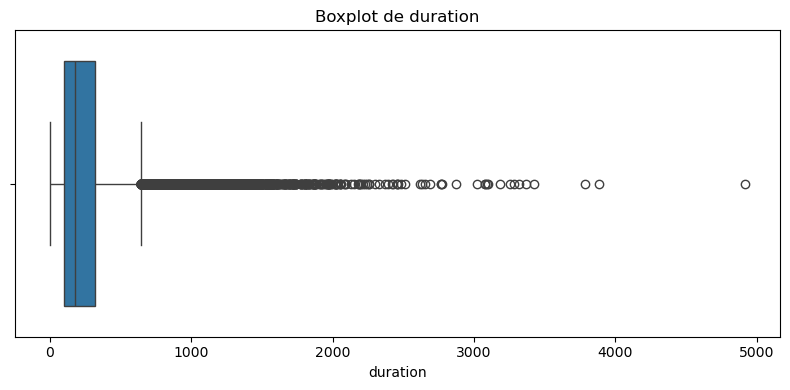

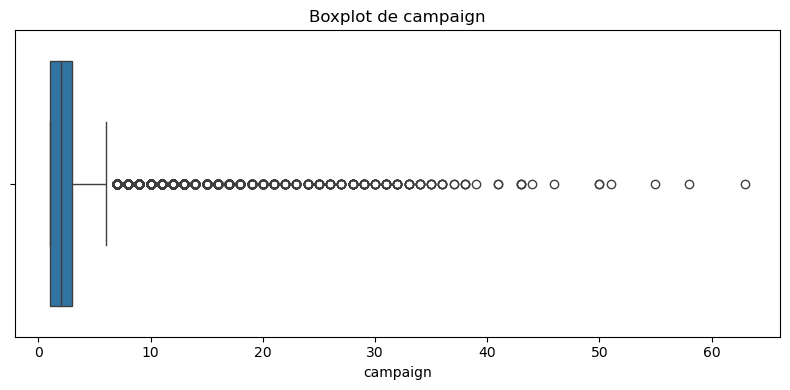

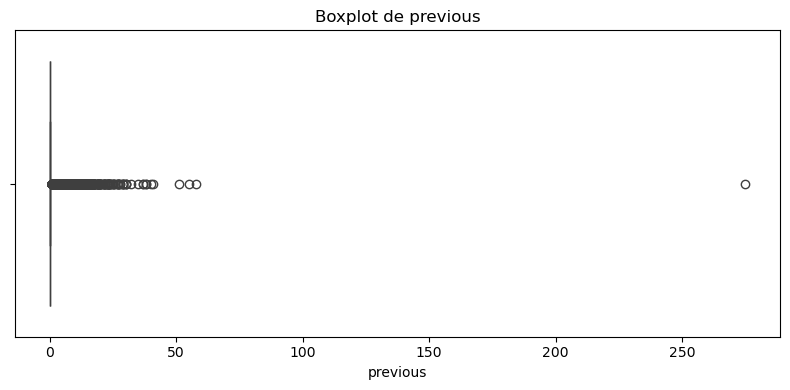

In [4]:
# 2) Déterminer si nous avons des valeurs abérrantes dans toutes les colonnes numeriques :

colonnes_numeriques = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Créer un boxplot pour chaque colonne
for col in colonnes_numeriques:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [5]:
# 3) mettre le log afin de ne pas supprimer les valeurs abérrantes :

df_clean["previous_log"] = np.log1p(df_clean["previous"])
df_clean["solde_bancaire_log"] = np.log1p(df_clean["solde_bancaire"])
df_clean["duration_log"] = np.log1p(df_clean["duration"])
df_clean["campaign_log"] = np.log1p(df_clean["campaign"])


c:\Users\compte\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\compte\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# 4) Suppression des colonnes inutiles suite à la mise en place du log :

colonnes_inutiles2 = ['duration','previous', 'campaign','solde_bancaire']
df_clean2 = df_clean.drop(columns =colonnes_inutiles2)
df_clean2.head()

,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,pret_immo,pret_conso,day,mois,resultat_precedent,souscription,segment_contact,previous_log,solde_bancaire_log,duration_log,campaign_log
0,58,management,married,tertiary,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,7.670429,5.568345,0.693147
1,44,technician,single,secondary,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,3.401197,5.023881,0.693147
2,33,entrepreneur,married,secondary,no,yes,yes,5,may,no existant,no,Jamais contacte,0.0,1.098612,4.343805,0.693147
3,47,blue-collar,married,unknown,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,7.317876,4.532599,0.693147
4,33,unknown,single,unknown,no,no,no,5,may,no existant,no,Jamais contacte,0.0,0.693147,5.293305,0.693147


In [7]:
# 5) Séparer les variables explicatives x et la variable cible y : 
target_variable = 'souscription'
y = df_clean2.loc[: , target_variable]
x = df_clean2.drop(columns= target_variable)
print("x :")
print(x.head())
print()
print("y : ")
print(y.head())


x :
   age        metier statut_matrimonial niveau_etudes defaut_credit pret_immo  \
0   58    management            married      tertiary            no       yes   
1   44    technician             single     secondary            no       yes   
2   33  entrepreneur            married     secondary            no       yes   
3   47   blue-collar            married       unknown            no       yes   
4   33       unknown             single       unknown            no        no   

  pret_conso  day mois resultat_precedent  segment_contact  previous_log  \
0         no    5  may        no existant  Jamais contacte           0.0   
1         no    5  may        no existant  Jamais contacte           0.0   
2        yes    5  may        no existant  Jamais contacte           0.0   
3         no    5  may        no existant  Jamais contacte           0.0   
4         no    5  may        no existant  Jamais contacte           0.0   

   solde_bancaire_log  duration_log  campaign_log  


In [8]:
# 6) Détecter les noms des variables numeriques / catégorielles:

num_cols = x.select_dtypes(include=["int64","float64"]).columns
print(f'Found numeric features {list(num_cols)}')


cat_cols = x.select_dtypes(include=["object", "category"]).columns
print(f"Found categorical features {list(cat_cols)}")

Found numeric features ['age', 'day', 'previous_log', 'solde_bancaire_log', 'duration_log', 'campaign_log']
Found categorical features ['metier', 'statut_matrimonial', 'niveau_etudes', 'defaut_credit', 'pret_immo', 'pret_conso', 'mois', 'resultat_precedent', 'segment_contact']


In [9]:
# 7) Séparer les données pour créer un ensemble de données d'entrainement et un ensemble de données de test (20% de la data):
from sklearn.model_selection import train_test_split


x_train,x_test, y_train,y_test = train_test_split (x,y, test_size = 0.2, random_state=42)

In [10]:


#Remplacer infinities
x_train = x_train.replace([np.inf, -np.inf], np.nan)

#Remplacer NaN
x_train = x_train.fillna(0)

#Vérifier variance nulle
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold() 
vt.fit(x_train[num_cols])
zero_var_cols = [c for c, v in zip(num_cols, vt.variances_) if v == 0]
print("Colonnes à variance nulle :", zero_var_cols)

Colonnes à variance nulle : []


In [11]:
# 8) Créer un pipeline pour les num_cols ainsi que les cat_cols  :

# A) il n'y aura pas d'imputation car nous n'avons pas de valeurs manquantes.
# B) standardisation pour les num_cols car on va utiliser une régression logistique,  
# C) Encodage des cat_cols :

from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


numeric_transformer = Pipeline(steps=[ 
    ('scaler', StandardScaler())])
    
categorical_transformer = Pipeline(steps=[
   
    ('encoder', OneHotEncoder(drop='first')) ])

print('....Done.')

....Done.


In [12]:
# 9) création objet préprocesseur avec ColumnTransformer :

from sklearn.compose import ColumnTransformer


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols ),
        ('cat', categorical_transformer, cat_cols)
    ]
)
x_train = preprocessor.fit_transform(x_train)
print(x_train[0:5, :])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 58 stored elements and shape (5, 41)>
  Coords	Values
  (0, 0)	0.006514948449407755
  (0, 1)	-0.0982181693341559
  (0, 2)	-0.4251236883477022
  (0, 3)	0.5140233073973149
  (0, 4)	-0.9511690143172365
  (0, 5)	-0.9075872034676993
  (0, 6)	1.0
  (0, 17)	1.0
  (0, 23)	1.0
  (0, 32)	1.0
  (0, 36)	1.0
  (0, 39)	1.0
  (1, 0)	0.7599367086994201
  (1, 1)	1.7034223914978113
  (1, 2)	-0.4251236883477022
  (1, 3)	0.6968747773169675
  (1, 4)	0.4678041927163298
  (1, 5)	-0.11630476694352175
  (1, 14)	1.0
  (1, 17)	1.0
  (1, 23)	1.0
  (1, 29)	1.0
  (1, 36)	1.0
  (1, 39)	1.0
  (2, 0)	0.1006926684806593
  :	:
  (2, 36)	1.0
  (2, 39)	1.0
  (3, 0)	-0.3701959316755984
  (3, 1)	-0.5786556522226806
  (3, 2)	-0.4251236883477022
  (3, 3)	-1.902679895802328
  (3, 4)	0.8270785261068283
  (3, 5)	2.5891077528288218
  (3, 9)	1.0
  (3, 18)	1.0
  (3, 20)	1.0
  (3, 23)	1.0
  (3, 30)	1.0
  (3, 36)	1.0
  (3, 39)	1.0
  (4, 0)	1.419180748918181
  (4, 1)	-0.098

In [13]:
#Remplacer infinities
x_test = x_test.replace([np.inf, -np.inf], np.nan)

#Remplacer NaN
x_test = x_test.fillna(0)

#Vérifier variance nulle
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold() 
vt.fit(x_test[num_cols])
zero_var_cols = [c for c, v in zip(num_cols, vt.variances_) if v == 0]
print("Colonnes à variance nulle :", zero_var_cols)

Colonnes à variance nulle : []


In [14]:
x_test = preprocessor.transform(x_test)
print(x_test[0:5, : ])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 59 stored elements and shape (5, 41)>
  Coords	Values
  (0, 0)	-0.08766277158184378
  (0, 1)	0.021891201387975245
  (0, 2)	-0.4251236883477022
  (0, 3)	0.37770180540036075
  (0, 4)	0.10357786358901881
  (0, 5)	-0.9075872034676993
  (0, 6)	1.0
  (0, 17)	1.0
  (0, 19)	1.0
  (0, 23)	1.0
  (0, 32)	1.0
  (0, 36)	1.0
  (0, 39)	1.0
  (1, 0)	0.571581268636917
  (1, 1)	-0.8188743936669428
  (1, 2)	-0.4251236883477022
  (1, 3)	1.0356386084021705
  (1, 4)	-0.7988991080614334
  (1, 5)	-0.11630476694352175
  (1, 12)	1.0
  (1, 18)	1.0
  (1, 19)	1.0
  (1, 30)	1.0
  (1, 36)	1.0
  (1, 39)	1.0
  :	:
  (2, 23)	1.0
  (2, 36)	1.0
  (2, 39)	1.0
  (3, 0)	0.1006926684806593
  (3, 1)	-0.8188743936669428
  (3, 2)	0.8750916544707351
  (3, 3)	0.77763207347363
  (3, 4)	0.6246564626576626
  (3, 5)	-0.9075872034676993
  (3, 9)	1.0
  (3, 17)	1.0
  (3, 20)	1.0
  (4, 0)	1.419180748918181
  (4, 1)	0.622438054998631
  (4, 2)	-0.4251236883477022
  (4, 3)	0.0264

## Baseline model (logistic regression)

In [21]:
# 1) Entrainement d'un modele de regression logistique et evaluation de ses performances :

from sklearn.linear_model import LogisticRegression


print('Train model ...')
model_lr = LogisticRegression(max_iter=1000,class_weight='balanced') # class_weight est important pour les données déséquilibrée
model_lr.fit(x_train,y_train)

print( '....Done.')

Train model ...
....Done.


In [22]:
# Prediction sur train : 
y_train_pred = model_lr.predict(x_train)
print('....Done.')
print(y_train_pred[0:5])

....Done.
['no' 'no' 'no' 'no' 'yes']


In [23]:
# Prediction sur test : 
y_test_pred = model_lr.predict(x_test)
print('....Done.')
print(y_test_pred[0:5])

....Done.
['no' 'no' 'yes' 'yes' 'no']


In [24]:
# Evaluation des performances : 

# Print scores :

from sklearn.metrics import accuracy_score, f1_score


print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred))


print(" F1_score on training set : ", f1_score(y_train, y_train_pred, pos_label='yes'))
print(" F1_score on test set : ", f1_score(y_test, y_test_pred, pos_label='yes'))

# Analyse des scores : 
# score Train f1 ≃ score Test f1 
# 

Accuracy on training set :  0.8202554744525548
Accuracy on test set :  0.8161008514873382
 F1_score on training set :  0.5208932124695999
 F1_score on test set :  0.5211632594298877


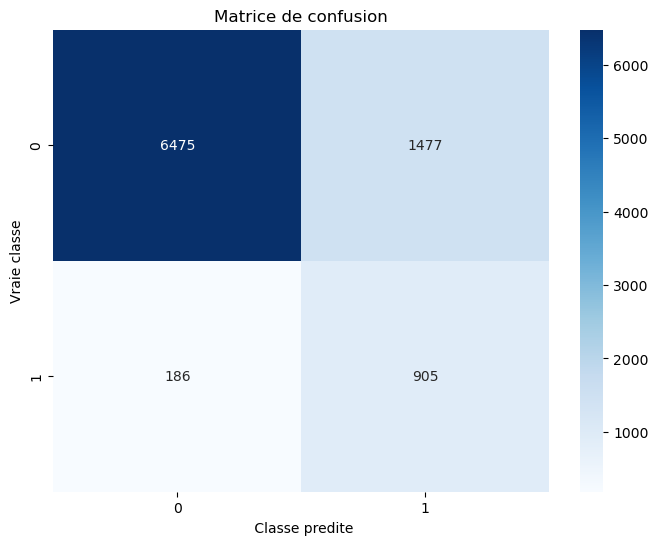

In [25]:
# Vérifier la matrice de confusion :
from sklearn.metrics import confusion_matrix
cm = confusion_matrix (y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap ='Blues')
plt.title('Matrice de confusion')
plt.ylabel('Vraie classe')
plt.xlabel(' Classe predite')
plt.show()

# analyse de la matrice: 


In [27]:
feature_names_final = preprocessor.get_feature_names_out()
print(feature_names_final)

['num__age' 'num__day' 'num__previous_log' 'num__solde_bancaire_log'
 'num__duration_log' 'num__campaign_log' 'cat__metier_blue-collar'
 'cat__metier_entrepreneur' 'cat__metier_housemaid'
 'cat__metier_management' 'cat__metier_retired'
 'cat__metier_self-employed' 'cat__metier_services' 'cat__metier_student'
 'cat__metier_technician' 'cat__metier_unemployed' 'cat__metier_unknown'
 'cat__statut_matrimonial_married' 'cat__statut_matrimonial_single'
 'cat__niveau_etudes_secondary' 'cat__niveau_etudes_tertiary'
 'cat__niveau_etudes_unknown' 'cat__defaut_credit_yes'
 'cat__pret_immo_yes' 'cat__pret_conso_yes' 'cat__mois_aug'
 'cat__mois_dec' 'cat__mois_feb' 'cat__mois_jan' 'cat__mois_jul'
 'cat__mois_jun' 'cat__mois_mar' 'cat__mois_may' 'cat__mois_nov'
 'cat__mois_oct' 'cat__mois_sep' 'cat__resultat_precedent_no existant'
 'cat__resultat_precedent_success'
 'cat__segment_contact_Intermediaire (31-90j)'
 'cat__segment_contact_Jamais contacte'
 'cat__segment_contact_Recent (0-30j)']


In [ ]:
# Déterminer les top features : 

# Régression Logistique (coefficients)
importance_lr = pd.DataFrame({
    'feature': feature_names_final,
    'importance': np.abs(model_lr.coef_[0]),  # Valeur absolue des coefficients
    'importance_signe': model_lr.coef_[0],    # Avec signe (positif/négatif)
    'model': 'Régression Logistique'
})

# Trier par importance décroissante
importance_lr = importance_lr.sort_values('importance', ascending=False).reset_index(drop=True)

print("📊 Top 5 - Régression Logistique:")
print(importance_lr.head())

# Analyse: 
# succées (déja client) est le meilleur prédicteur
# le timing est crucial (mars est bon, janvier / mai mauvais)
# la durée d'appel est un levier d'action

📊 Top 5 - Régression Logistique:
                           feature  importance  importance_signe  \
0  cat__resultat_precedent_success    2.355360          2.355360   
1                    cat__mois_mar    1.959542          1.959542   
2                num__duration_log    1.939848          1.939848   
3                    cat__mois_jan    1.436115         -1.436115   
4                    cat__mois_may    1.364516         -1.364516   

                   model  
0  Régression Logistique  
1  Régression Logistique  
2  Régression Logistique  
3  Régression Logistique  
4  Régression Logistique  


Afin d'améliorer notre modele de base nous allons entrainer un autre modele Random forest ce dernier peut gérer ce trade-off

## Random Forest

In [86]:
# Modele Random Forest : 
from sklearn.ensemble import RandomForestClassifier


classifier = RandomForestClassifier( 
    n_estimators=100,
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=25,
    class_weight = 'balanced',
    random_state=42,
    max_features ='sqrt',
    n_jobs= -1)
classifier.fit(x_train, y_train)
print('...Done.')

...Done.


In [87]:
# Prediction  :
y_pred_train = classifier.predict(x_train)
print('y_pred_train....Done.')
print(y_pred_train[0:5])
y_pred_test = classifier.predict(x_test)
print('y_pred_test....Done.')
print(y_test_pred[0:5])

y_pred_train....Done.
['no' 'no' 'no' 'no' 'no']
y_pred_test....Done.
['no' 'no' 'yes' 'yes' 'no']


In [88]:
# Evaluation des performances : 

# Print scores :

print("Accuracy on training set : ", accuracy_score(y_train, y_pred_train))
print("Accuracy on test set : ", accuracy_score(y_test, y_pred_test))


print(" F1_score on training set : ", f1_score(y_train, y_pred_train, pos_label='yes'))
print(" F1_score on test set : ", f1_score(y_test, y_pred_test, pos_label='yes'))

# Analyse des scores: 

Accuracy on training set :  0.8388630833886308
Accuracy on test set :  0.8302554462014818
 F1_score on training set :  0.5615407764068613
 F1_score on test set :  0.5470640306875184


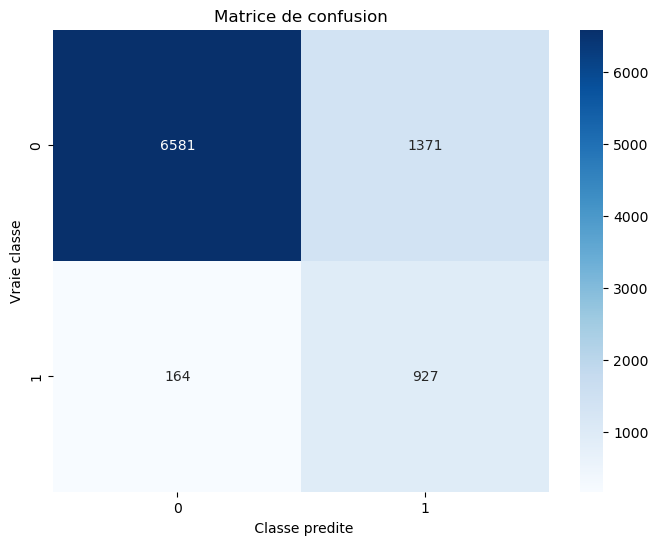

In [89]:
cm = confusion_matrix (y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap ='Blues')
plt.title('Matrice de confusion')
plt.ylabel('Vraie classe')
plt.xlabel(' Classe predite')
plt.show()

/!\ Conclusion  : 

In [118]:
# Dans le but d'améliorer le socre F1 on peut optimiser les hyperparametres (GridSearchCV): 

# 1) Garder le modele random forest de base: 

from sklearn.model_selection import GridSearchCV


classifier = RandomForestClassifier(
    class_weight = 'balanced', # bon point de départ
    random_state = 42,
    n_jobs = -1
)
# 2) Définir les hyperparametres à optimiser : 
param_grid = {
    'n_estimators' : [100,150],  # Nombre d'arbre
    'max_depth' : [15,20,None] ,     # profondeur max
    'min_samples_split' : [5,10],     # échantillon min pour diviser
    'min_samples_leaf' : [2,4]       # échantillon min par feuille 
}

# 3) Lancer le gridSearchCV :

grid_search = GridSearchCV(
    estimator = classifier,
    param_grid= param_grid,
    scoring = 'f1_weighted',        # optimise pour le f1_score
    cv = 5,                # validation croisée 3_fold
    n_jobs = -1,           # utilise tous les CPU
    verbose = 1            # montre la progression 
)

print(' Optimisation avec GridSearchCV ....')

grid_search.fit(x_train, y_train)

print('....Done.')

# 4) Récupération du meilleur modele :

best_classifier = grid_search.best_estimator_

print(' Meilleurs parametres:', grid_search.best_params_)
print(' Meilleur score validation:', grid_search.best_score_)


 Optimisation avec GridSearchCV ....
Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

In [92]:
!pip install xgboost

In [93]:
import xgboost as xgb
from xgboost import XGBClassifier


In [95]:
# convertir y avant GridSearch :
y_train = y_train.map({'yes': 1, 'no': 0})
y_test = y_test.map({'yes': 1, 'no': 0})

In [ ]:
# # Perform grid search
# print("Grid search...")
# xgboost = XGBClassifier()

# # Grid of values to be tested
# params = {
#     'max_depth': [4, 6, 8],
#     'min_child_weight': [1, 3,5],
#     'n_estimators': [200,300],
#     'learning_rate' : [0.01,0.05,0.1],
#     'subsample' : [0.7,0.8,0.9],
#     'colsample_bytree' : [0.7,0.8,0.9]
    
# }
# print(params)
# gridsearch = GridSearchCV(xgboost, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
# gridsearch.fit(x_train, y_train)
# print("...Done.")
# print("Best hyperparameters : ", gridsearch.best_params_)
# print("Best validation accuracy : ", gridsearch.best_score_)
# best_model = gridsearch.best_estimator_
# y_train_pred =best_model.predict(x_train)
# y_test_pred = best_model.predict(x_test)

# print(" Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
# print(" Accuracy on test set : ", accuracy_score(y_test, y_test_pred))
# print()
# print(" F1_score on training set : ", f1_score(y_train, y_train_pred))
# print(" F1_score on test set : ", f1_score(y_test, y_test_pred))

Grid search...
{'max_depth': [4, 6, 8], 'min_child_weight': [1, 3, 5], 'n_estimators': [200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]}
Fitting 3 folds for each of 486 candidates, totalling 1458 fits


KeyboardInterrupt: 

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np



# 1. CALCUL DU POIDS POUR CLASSES DÉSÉQUILIBRÉES
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"⚖️ scale_pos_weight: {scale_pos_weight:.2f}")

# 2. MODÈLE XGBOOST AVEC BONS PARAMÈTRES DE BASE
xgboost = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight  # ← Équilibrage automatique
)

# 3. GRILLE DE PARAMÈTRES
params = {
    'max_depth': [5, 6,7],
    'min_child_weight': [2, 3,4],
    'n_estimators': [ 300],
    'learning_rate': [0.08,0.1,0.12],
    'subsample': [ 0.8],
    'colsample_bytree': [0.8]
}

print("📊 Paramètres à tester:")
print(params)

# 4. VALIDATION CROISÉE STRATIFIÉE (optionnel mais mieux)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 5. GRIDSEARCH
print("\n🔍 Grid search en cours...")
gridsearch = GridSearchCV(
    xgboost,
    param_grid=params,
    cv=cv,  # ou cv=3
    scoring='f1',  # ← Optimiser F1 plutôt qu'accuracy
    n_jobs=-1,
    verbose=1
)

# 6. ENTRAÎNEMENT 
gridsearch.fit(x_train, y_train)  
print("✅ Grid search terminé!")

# 7. RÉSULTATS
print("\n" + "="*50)
print("📊 RÉSULTATS DE L'OPTIMISATION")
print("="*50)
print(f"Meilleurs hyperparamètres: {gridsearch.best_params_}")
print(f"Meilleur score F1 (validation): {gridsearch.best_score_:.4f}")

# 8. MEILLEUR MODÈLE
best_model = gridsearch.best_estimator_

# 9. PRÉDICTIONS (AVEC les données transformées)
y_train_pred = best_model.predict(x_train)
y_test_pred = best_model.predict(x_test)

# 10. ÉVALUATION FINALE
print("\n" + "="*50)
print("📈 PERFORMANCES FINALES")
print("="*50)
print(f"Accuracy - Train: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Accuracy - Test:  {accuracy_score(y_test, y_test_pred):.4f}")
print()
print(f"F1-score - Train: {f1_score(y_train, y_train_pred):.4f}")
print(f"F1-score - Test:  {f1_score(y_test, y_test_pred):.4f}")


⚖️ scale_pos_weight: 7.62
📊 Paramètres à tester:
{'max_depth': [5, 6, 7], 'min_child_weight': [2, 3, 4], 'n_estimators': [300], 'learning_rate': [0.08, 0.1, 0.12], 'subsample': [0.8], 'colsample_bytree': [0.8]}

🔍 Grid search en cours...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\compte\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:23:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Grid search terminé!

📊 RÉSULTATS DE L'OPTIMISATION
Meilleurs hyperparamètres: {'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}
Meilleur score F1 (validation): 0.6043

📈 PERFORMANCES FINALES
Accuracy - Train: 0.9225
Accuracy - Test:  0.8754

F1-score - Train: 0.7467
F1-score - Test:  0.6094


## II - Lancement d'un plan Machine Learning sans la variable 'duration' :

In [27]:
#1)  Supprimer les colonnes inutiles :

colonnes_inutiles = ['pdays','age_group','duration']
data_clean = df.drop(columns =colonnes_inutiles)
data_clean.head()

,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,solde_bancaire,pret_immo,pret_conso,day,mois,campaign,previous,resultat_precedent,souscription,segment_contact
0,58,management,married,tertiary,no,2143,yes,no,5,may,1,0,no existant,no,Jamais contacte
1,44,technician,single,secondary,no,29,yes,no,5,may,1,0,no existant,no,Jamais contacte
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1,0,no existant,no,Jamais contacte
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,1,0,no existant,no,Jamais contacte
4,33,unknown,single,unknown,no,1,no,no,5,may,1,0,no existant,no,Jamais contacte


In [28]:
# 2) mettre le log afin de ne pas supprimer les valeurs abérrantes :

data_clean["previous_log"] = np.log1p(data_clean["previous"])
data_clean["solde_bancaire_log"] = np.log1p(data_clean["solde_bancaire"])
data_clean["campaign_log"] = np.log1p(data_clean["campaign"])


c:\Users\compte\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\compte\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
# 3) Suppression des colonnes inutiles suite à la mise en place du log :

colonnes_inutiles2 = ['previous', 'campaign','solde_bancaire']
data_clean2 = data_clean.drop(columns =colonnes_inutiles2)
data_clean2.head()

,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,pret_immo,pret_conso,day,mois,resultat_precedent,souscription,segment_contact,previous_log,solde_bancaire_log,campaign_log
0,58,management,married,tertiary,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,7.670429,0.693147
1,44,technician,single,secondary,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,3.401197,0.693147
2,33,entrepreneur,married,secondary,no,yes,yes,5,may,no existant,no,Jamais contacte,0.0,1.098612,0.693147
3,47,blue-collar,married,unknown,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,7.317876,0.693147
4,33,unknown,single,unknown,no,no,no,5,may,no existant,no,Jamais contacte,0.0,0.693147,0.693147


In [31]:
# 4) Séparer les variables explicatives x et la variable cible y : 
target_variable = 'souscription'
y = data_clean2.loc[: , target_variable]
x = data_clean2.drop(columns= target_variable)
print("x :")
print(x.head())
print()
print("y : ")
print(y.head())

x :
   age        metier statut_matrimonial niveau_etudes defaut_credit pret_immo  \
0   58    management            married      tertiary            no       yes   
1   44    technician             single     secondary            no       yes   
2   33  entrepreneur            married     secondary            no       yes   
3   47   blue-collar            married       unknown            no       yes   
4   33       unknown             single       unknown            no        no   

  pret_conso  day mois resultat_precedent  segment_contact  previous_log  \
0         no    5  may        no existant  Jamais contacte           0.0   
1         no    5  may        no existant  Jamais contacte           0.0   
2        yes    5  may        no existant  Jamais contacte           0.0   
3         no    5  may        no existant  Jamais contacte           0.0   
4         no    5  may        no existant  Jamais contacte           0.0   

   solde_bancaire_log  campaign_log  
0            7

In [32]:
# 5) Détecter les noms des variables numeriques / catégorielles:

num_cols = x.select_dtypes(include=["int64","float64"]).columns
print(f'Found numeric features {list(num_cols)}')


cat_cols = x.select_dtypes(include=["object", "category"]).columns
print(f"Found categorical features {list(cat_cols)}")

Found numeric features ['age', 'day', 'previous_log', 'solde_bancaire_log', 'campaign_log']
Found categorical features ['metier', 'statut_matrimonial', 'niveau_etudes', 'defaut_credit', 'pret_immo', 'pret_conso', 'mois', 'resultat_precedent', 'segment_contact']


In [54]:
months_order = ['jan','feb','mar','apr','may','jun',
                'jul','aug','sep','oct','nov','dec']

data_clean2['mois'] = pd.Categorical(
    data_clean2['mois'],
    categories=months_order,
    ordered=True
)

data_clean2 = data_clean2.sort_values("mois")

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

numeric_cols = ['age','day','previous_log','solde_bancaire_log','campaign_log']
categorical_cols = ['metier','statut_matrimonial','niveau_etudes',
                    'defaut_credit','pret_immo','pret_conso',
                    'mois','resultat_precedent','segment_contact']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ]
)

model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

In [ ]:
from sklearn.metrics import roc_auc_score


logistic_model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        solver="lbfgs"
    ))
])

def evaluate_model(model, data_clean2, months_order, target_col="souscription"):
    results = []
    for i in range(6, len(months_order)-1):
    
        train_months = months_order[:i]
        test_month = months_order[i]
        train = data_clean2[data_clean2['mois'].isin(train_months)]
        test  = data_clean2[data_clean2['mois'] == test_month]
        X_train = train.drop(columns=[target_col])
        y_train = train[target_col]
        X_test = test.drop(columns=[target_col])
        y_test = test[target_col]
        X_test = pd.DataFrame(X_test.values, columns=X_train.columns)
        #Remplacer infinities
        X_test = x_test.replace([np.inf, -np.inf], np.nan)
        #Remplacer NaN
        X_test = x_test.fillna(0)
        #Vérifier variance nulle
        from sklearn.feature_selection import VarianceThreshold
        vt = VarianceThreshold() 
        vt.fit(x_test[num_cols])
        zero_var_cols = [c for c, v in zip(num_cols, vt.variances_) if v == 0]
        print("Colonnes à variance nulle :", zero_var_cols)
       #Remplacer infinities
        X_train = x_train.replace([np.inf, -np.inf], np.nan)
        #Remplacer NaN
        X_train = x_train.fillna(0)
         #Vérifier variance nulle
        from sklearn.feature_selection import VarianceThreshold
        vt = VarianceThreshold() 
        vt.fit(x_train[num_cols])
        zero_var_cols = [c for c, v in zip(num_cols, vt.variances_) if v == 0]
        print("Colonnes à variance nulle :", zero_var_cols)
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_test, proba)
        results.append((test_month, score))
    return results
evaluate_model(logistic_model, data_clean2, months_order, target_col="souscription")

AttributeError: 'csr_matrix' object has no attribute 'replace'

In [33]:
# 6) Séparer les données pour créer un ensemble de données d'entrainement et un ensemble de données de test (20% de la data):
from sklearn.model_selection import train_test_split


x_train,x_test, y_train,y_test = train_test_split (x,y, test_size = 0.2, random_state=42)

In [34]:

#Remplacer infinities
x_train = x_train.replace([np.inf, -np.inf], np.nan)

#Remplacer NaN
x_train = x_train.fillna(0)

#Vérifier variance nulle
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold() 
vt.fit(x_train[num_cols])
zero_var_cols = [c for c, v in zip(num_cols, vt.variances_) if v == 0]
print("Colonnes à variance nulle :", zero_var_cols)

Colonnes à variance nulle : []


In [35]:
# 7) Créer un pipeline pour les num_cols ainsi que les cat_cols  :

# A) il n'y aura pas d'imputation car nous n'avons pas de valeurs manquantes.
# B) standardisation pour les num_cols car on va utiliser une régression logistique,  
# C) Encodage des cat_cols :

from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


numeric_transformer = Pipeline(steps=[ 
    ('scaler', StandardScaler())])
    
categorical_transformer = Pipeline(steps=[
   
    ('encoder', OneHotEncoder(drop='first')) ])

print('....Done.')

....Done.


In [36]:
# 8) création objet préprocesseur avec ColumnTransformer :

from sklearn.compose import ColumnTransformer


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols ),
        ('cat', categorical_transformer, cat_cols)
    ]
)
x_train = preprocessor.fit_transform(x_train)
print(x_train[0:5, :])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 53 stored elements and shape (5, 40)>
  Coords	Values
  (0, 0)	0.006514948449407755
  (0, 1)	-0.0982181693341559
  (0, 2)	-0.4251236883477022
  (0, 3)	0.5140233073973149
  (0, 4)	-0.9075872034676993
  (0, 5)	1.0
  (0, 16)	1.0
  (0, 22)	1.0
  (0, 31)	1.0
  (0, 35)	1.0
  (0, 38)	1.0
  (1, 0)	0.7599367086994201
  (1, 1)	1.7034223914978113
  (1, 2)	-0.4251236883477022
  (1, 3)	0.6968747773169675
  (1, 4)	-0.11630476694352175
  (1, 13)	1.0
  (1, 16)	1.0
  (1, 22)	1.0
  (1, 28)	1.0
  (1, 35)	1.0
  (1, 38)	1.0
  (2, 0)	0.1006926684806593
  (2, 1)	1.8235317622199425
  (2, 2)	-0.4251236883477022
  :	:
  (2, 18)	1.0
  (2, 28)	1.0
  (2, 35)	1.0
  (2, 38)	1.0
  (3, 0)	-0.3701959316755984
  (3, 1)	-0.5786556522226806
  (3, 2)	-0.4251236883477022
  (3, 3)	-1.902679895802328
  (3, 4)	2.5891077528288218
  (3, 8)	1.0
  (3, 17)	1.0
  (3, 19)	1.0
  (3, 22)	1.0
  (3, 29)	1.0
  (3, 35)	1.0
  (3, 38)	1.0
  (4, 0)	1.419180748918181
  (4, 1)	-0.098

In [37]:
#Remplacer infinities
x_test = x_test.replace([np.inf, -np.inf], np.nan)

#Remplacer NaN
x_test = x_test.fillna(0)

#Vérifier variance nulle
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold() 
vt.fit(x_test[num_cols])
zero_var_cols = [c for c, v in zip(num_cols, vt.variances_) if v == 0]
print("Colonnes à variance nulle :", zero_var_cols)

Colonnes à variance nulle : []


In [38]:
x_test = preprocessor.transform(x_test)
print(x_test[0:5, : ])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 54 stored elements and shape (5, 40)>
  Coords	Values
  (0, 0)	-0.08766277158184378
  (0, 1)	0.021891201387975245
  (0, 2)	-0.4251236883477022
  (0, 3)	0.37770180540036075
  (0, 4)	-0.9075872034676993
  (0, 5)	1.0
  (0, 16)	1.0
  (0, 18)	1.0
  (0, 22)	1.0
  (0, 31)	1.0
  (0, 35)	1.0
  (0, 38)	1.0
  (1, 0)	0.571581268636917
  (1, 1)	-0.8188743936669428
  (1, 2)	-0.4251236883477022
  (1, 3)	1.0356386084021705
  (1, 4)	-0.11630476694352175
  (1, 11)	1.0
  (1, 17)	1.0
  (1, 18)	1.0
  (1, 29)	1.0
  (1, 35)	1.0
  (1, 38)	1.0
  (2, 0)	-1.500328572050617
  (2, 1)	0.5023286842764999
  :	:
  (2, 17)	1.0
  (2, 19)	1.0
  (2, 22)	1.0
  (2, 35)	1.0
  (2, 38)	1.0
  (3, 0)	0.1006926684806593
  (3, 1)	-0.8188743936669428
  (3, 2)	0.8750916544707351
  (3, 3)	0.77763207347363
  (3, 4)	-0.9075872034676993
  (3, 8)	1.0
  (3, 16)	1.0
  (3, 19)	1.0
  (4, 0)	1.419180748918181
  (4, 1)	0.622438054998631
  (4, 2)	-0.4251236883477022
  (4, 3)	0.026492

## Baseline model (logistic regression)

In [39]:
# 1) Entrainement d'un modele de regression logistique et evaluation de ses performances :

from sklearn.linear_model import LogisticRegression


print('Train model ...')
model = LogisticRegression(max_iter=1000,class_weight='balanced') # class_weight est important pour les données déséquilibrée
model.fit(x_train,y_train)

print( '....Done.')

Train model ...
....Done.


In [40]:
# Prediction sur train : 
y_train_pred = model.predict(x_train)
print('....Done.')
print(y_train_pred[0:5])

....Done.
['no' 'no' 'no' 'no' 'yes']


In [41]:
# Prediction sur test : 
y_test_pred = model.predict(x_test)
print('....Done.')
print(y_test_pred[0:5])

....Done.
['no' 'yes' 'yes' 'yes' 'no']


In [42]:
# Evaluation des performances : 

# Print scores :

from sklearn.metrics import accuracy_score, f1_score


print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred))


print(" F1_score on training set : ", f1_score(y_train, y_train_pred, pos_label='yes'))
print(" F1_score on test set : ", f1_score(y_test, y_test_pred, pos_label='yes'))

# Analyse des scores : 

Accuracy on training set :  0.7649856226498563
Accuracy on test set :  0.7618047108260533
 F1_score on training set :  0.37573443008225615
 F1_score on test set :  0.3799654576856649


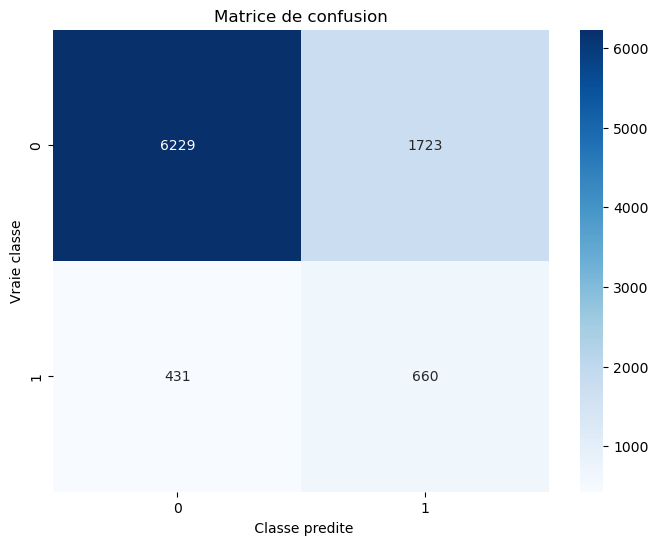

In [43]:
# Vérifier la matrice de confusion :
from sklearn.metrics import confusion_matrix
cm = confusion_matrix (y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap ='Blues')
plt.title('Matrice de confusion')
plt.ylabel('Vraie classe')
plt.xlabel(' Classe predite')
plt.show()

# analyse de la matrice: 

## Random Forest

In [44]:
# Modele Random Forest : 
from sklearn.ensemble import RandomForestClassifier


classifier = RandomForestClassifier( 
    n_estimators=100,
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=25,
    class_weight = 'balanced',
    random_state=42,
    max_features ='sqrt',
    n_jobs= -1)
classifier.fit(x_train, y_train)
print('...Done.')

...Done.


In [45]:
# Prediction  :
y_pred_train = classifier.predict(x_train)
print('y_pred_train....Done.')
print(y_pred_train[0:5])
y_pred_test = classifier.predict(x_test)
print('y_pred_test....Done.')
print(y_test_pred[0:5])

y_pred_train....Done.
['no' 'no' 'no' 'no' 'no']
y_pred_test....Done.
['no' 'yes' 'yes' 'yes' 'no']


In [46]:
# Evaluation des performances : 

# Print scores :

print("Accuracy on training set : ", accuracy_score(y_train, y_pred_train))
print("Accuracy on test set : ", accuracy_score(y_test, y_pred_test))


print(" F1_score on training set : ", f1_score(y_train, y_pred_train, pos_label='yes'))
print(" F1_score on test set : ", f1_score(y_test, y_pred_test, pos_label='yes'))

# Analyse des scores: 

Accuracy on training set :  0.824126299491263
Accuracy on test set :  0.8157691031737255
 F1_score on training set :  0.44759009986973514
 F1_score on test set :  0.4274914089347079


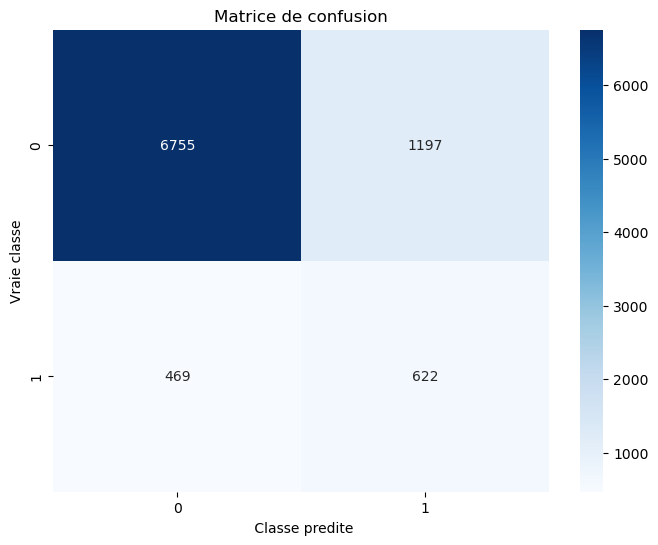

In [47]:
cm = confusion_matrix (y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap ='Blues')
plt.title('Matrice de confusion')
plt.ylabel('Vraie classe')
plt.xlabel(' Classe predite')
plt.show()

- Comparaison entre les deux plans ML (avec variable "duration & sans variable "duration)

------ML avec variable "duration" :

regression logistique : 
f1_score : train => 0.520 / test => 0.521
random forest :
f1_score : train => 0.56 / test => 0.54

------ML sans la variable "duration" : 

regression logistique : 
f1_score : train => 0.375 / test => 0.379
random forest : 
f1_score : train => 0.44 / test => 0.42

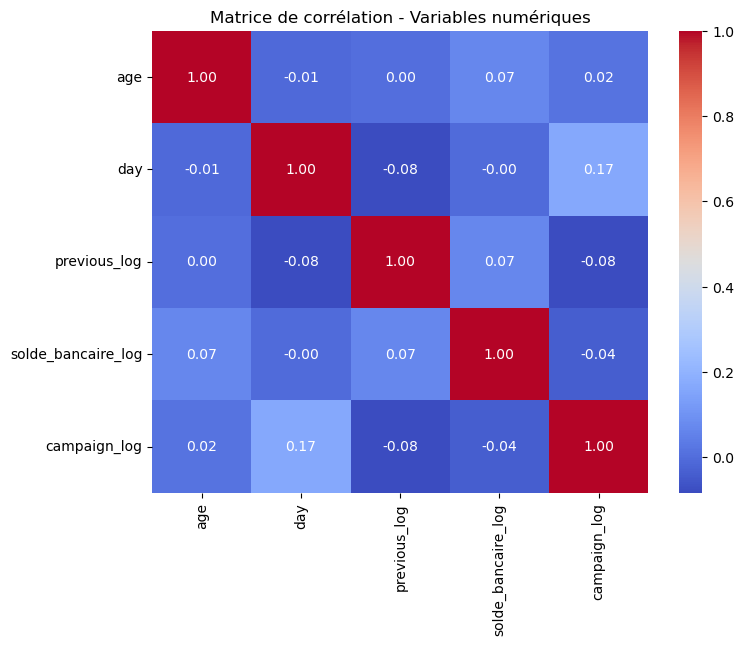

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['age', 'day', 'previous_log', 
                'solde_bancaire_log', 'campaign_log']

corr_matrix = data_clean2[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation - Variables numériques")
plt.show()

In [52]:
data_clean2.head()

,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,pret_immo,pret_conso,day,mois,resultat_precedent,souscription,segment_contact,previous_log,solde_bancaire_log,campaign_log
0,58,management,married,tertiary,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,7.670429,0.693147
1,44,technician,single,secondary,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,3.401197,0.693147
2,33,entrepreneur,married,secondary,no,yes,yes,5,may,no existant,no,Jamais contacte,0.0,1.098612,0.693147
3,47,blue-collar,married,unknown,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,7.317876,0.693147
4,33,unknown,single,unknown,no,no,no,5,may,no existant,no,Jamais contacte,0.0,0.693147,0.693147


In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler

# 1. Extraction
X = data_clean2[numeric_cols].copy()

# 2. Remplacement des valeurs infinies
X = X.replace([np.inf, -np.inf], np.nan)

# 3. Suppression des lignes contenant des NaN
X = X.dropna()

# 4. Suppression des colonnes constantes (variance nulle)
X = X.loc[:, X.var() > 0]

# 5. Standardisation (stabilise le calcul SVD)
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# 6. Ajout constante
X_const = add_constant(X_scaled)

# 7. Calcul du VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_const.values, i)
    for i in range(X_const.shape[1])
]

print(vif_data)

             Variable       VIF
0               const  1.000000
1                 age  1.004850
2                 day  1.031805
3        previous_log  1.015685
4  solde_bancaire_log  1.010166
5        campaign_log  1.034916


In [53]:
data_clean2["mois"].nunique()

12

In [60]:
data_clean2.head()

,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,pret_immo,pret_conso,day,mois,resultat_precedent,souscription,segment_contact,previous_log,solde_bancaire_log,campaign_log
27859,45,housemaid,married,primary,no,yes,no,28,jan,no existant,no,Jamais contacte,0.000000,7.331060,0.693147
28326,56,management,single,tertiary,no,yes,no,29,jan,no existant,no,Jamais contacte,0.000000,6.302619,0.693147
28325,37,technician,married,tertiary,no,yes,no,29,jan,failure,no,Ancien (>90j),0.693147,5.214936,0.693147
28324,34,admin.,single,secondary,no,yes,no,29,jan,failure,no,Ancien (>90j),1.098612,5.971262,0.693147
28323,35,blue-collar,married,secondary,no,yes,no,29,jan,no existant,no,Jamais contacte,0.000000,6.470800,0.693147
